### Machine learning with audio data - Preparation

In this and the next unit we will see how we can prepare, explore and analyze audio data with the help of machine learning. As for the other modalities, such as text or images, the trick is to get the data first into a machine interpretable format.

The interesting thing with audio data is that you can treat it as many different modalities:

* You can extract high-level features and analyze the data like tabular data.
* You can compute frequency plots and analyze the data like image data.
* You can use speech-to-text models and analyze the data like text data.
* You can use temporal sensitive models and analyze the data like time-series data.

In our course we will take a look at the first three approaches. But first, let’s take a closer look at what audio data.

The data we will be using for this use-case was downloaded from the Common Voice repository from Kaggle. This 14 GB big dataset is a small snapshot of a much bigger dataset from Mozilla. But don’t worry, for our use-case here we will use an ever smaller subsample of the full dataset, more about this later.

#### 1. Audio data
While there are multiple Python libraries that allow you the loading and manipulation of audio data (scipy is one of them), we will use librosa for this and the following unit.

So, let’s download the sample_?.mp3 files from the resources of this unit and load them with librosa.

In [1]:
import librosa

# Loads the mp3 file
y, sr = librosa.load("c4_sample-1.mp3", sr=16_000)

# Print some information
print(y, len(y), sr)

C:\Users\56975\anaconda3\envs\adsml\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 1.3191589e-05 6.7497815e-05
 5.3441840e-05] 50688 16000


The information we get from the audio file are y the audio time-series data represented as 50’688 individual data points and sr the sampling rate with which the audio data was read from the file (use sr=None to get the original sampling rate). To better understand what this time-series data contains, let’s plot it in a figure.

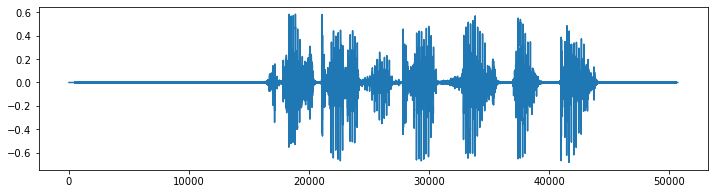

In [3]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 3))
plt.plot(y)
plt.show()

What you see here is the waveform representation of the spoken sentence: “he just got a new kite for his birthday”. Don’t believe me? Go ahead and open the mp3 file with your favorite audio player. Or even more simple, you can use the following code to listen to the audio data directly in your notebook:

import IPython.display as ipd
ipd.Audio(y, rate=sr)

#### Waveform - signal in the time-domain
But did we call it time-series data or waveform? Well, let’s take a closer look at a small segment of this signal.



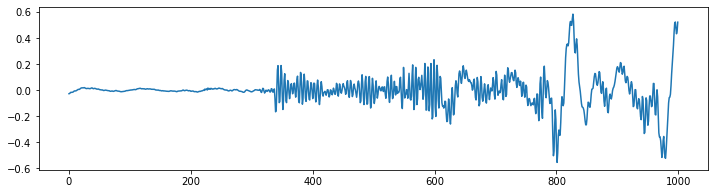

In [4]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 3))
plt.plot(y[17500:18500])
plt.show()

What you can see is a temporal signal that oscillates around the value 0 with different frequencies and amplitudes.This signal represents the air pressure change over time, or the physical displacement of a loud speaker’s membrane (or the membrane in your ear for that matter). That’s why this depiction of the audio data is also called waveform.

The frequency is the speed with which this signal oscillates. Low frequency, e.g. 60 Hz could be the sound of bass guitar, while a birds sound could be in the higher frequency of 8000 Hz. Human speech is usually anywhere between that.

To know how quickly this signal needs to be interpret, we also need to know the sampling rate at which the data was recorded. In this case, the sampling rate per second was 16’000 or 16k Hz. Which means that the 1’000 time points we can see in the previous figure represents 62.5 milliseconds (1000/16000 = 0.0625) of audio signal.

In some cases you might be rather interested in the envelope of the audio signal than the oscillating waveform. In that case you can just can compute the envelope function with the following code:

from scipy.signal import hilbert
y_envelope = np.abs(hilbert(y))

#### The Fourier Transform - signal in the frequency domain
While the previous visualization can tell us when something happens (i.e. around 2 seconds there seem to be a lot of waveforms), it cannot really tell us with what frequency it happens. Because we have information about the when, this is signal representation is said to be in the time domain.

Using a fast fourier transformation, we can invert this issue and get a clear information about what frequencies are present, while loosing all information about the when. In such a case, the signal representation is said to be in the frequency domain.

Let’s see what our spoken sentence from before looks like represented in the frequency domain.



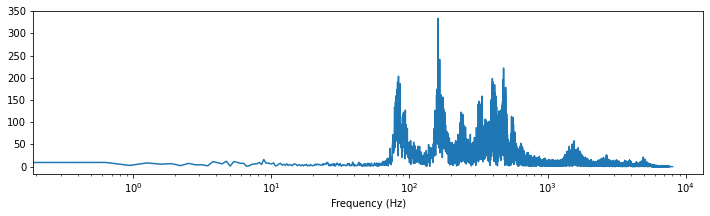

In [5]:
import scipy
import numpy as np

# Applies fast fourier transformation to the signal and takes absolute values
y_freq = np.abs(scipy.fftpack.fft(y))

#  Establishes all possible frequency (dependent on the sampling rate and the length of the signal)
f = np.linspace(0, sr, len(y_freq))

# Plot audio signal as frequency information.
plt.figure(figsize=(12, 3))
plt.semilogx(f[: len(f) // 2], y_freq[: len(f) // 2])
plt.xlabel("Frequency (Hz)")
plt.show()

What you can see here is that most of the signal is somewhere between ~100 and ~1000 Hz (i.e. between 10^2 and 10^3), plus there seem to be some additional thing closer to 10’000 Hz.

#### Spectrogram
Luckily, we don’t always need to decide for either the time or frequency domain. Using a spectrogram plot, we can profit from both domains, while keeping most of the handicaps minimal. There are multiple ways how you can create such spectrogram plots, but for this use-case let’s take a look at three in particular.

While spectrogram plots are very useful, for some analysis you might prefer to only look at one of the domains alone.

#### A. Short-time Fourier transform (STFT)
Using a small adapted version of the fast fourier transformation before, namely the short-time fourier transformation (STFT), we can create such a spectrogram. The small trick that is applied here is that the FFT is computed for multiple small time windows (hence “short-time fourier”) in a sliding window manner.

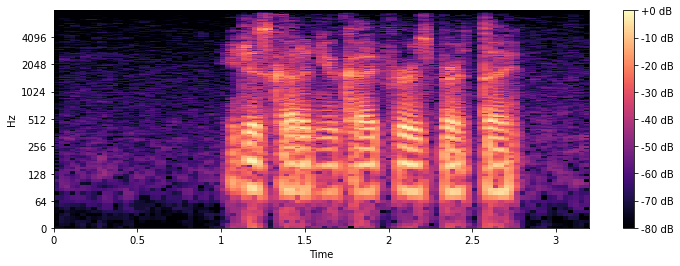

In [6]:
import librosa.display

# Compute short-time Fourier Transform
x_stft = np.abs(librosa.stft(y))

# Apply logarithmic dB-scale to spectrogram and set maximum to 0 dB
x_stft = librosa.amplitude_to_db(x_stft, ref=np.max)

# Plot STFT spectrogram
plt.figure(figsize=(12, 4))
librosa.display.specshow(x_stft, sr=sr, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.0f dB")
plt.show()


As in all spectrogram plots, the color represents the amount (loudness/volume) of a given frequency, at a given timepoint. +0dB is the loudest, and -80dB is silence. On the horizontal x-axis we can see the time, while on the vertical y-axis we can see the different frequencies.

The computation of these spectrogram plots, as well as their scaling can be influenced and changed by multiple different function parameters, such as n_fft, hop_length, win_length. The implication of changing these parameters would go into too much detail, but in short, they can control how detailed (i.e pixelated) the spectrogram plot looks.

#### B. Mel spectrogram
As an alternative to the STFT, you can also compute the mel spectrogram, which is based on the mel scale. This scale accounts for the way we human perceive a sounds pitch. The mel scale is calculated so that two pairs of frequencies separated by a delta in the mel scale are perceived by humans as having the same perceptual difference.

The mel spectrogram is computed very similar to the STFT, the main difference is just that the y-axis uses a different scale.

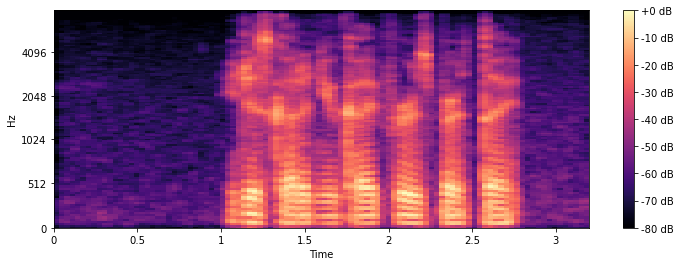

In [7]:
# Compute the mel spectrogram
x_mel = librosa.feature.melspectrogram(y=y, sr=sr)

# Apply logarithmic dB-scale to spectrogram and set maximum to 0 dB
x_mel = librosa.power_to_db(x_mel, ref=np.max)

# Plot mel spectrogram
plt.figure(figsize=(12, 4))
librosa.display.specshow(x_mel, sr=sr, x_axis="time", y_axis="mel")
plt.colorbar(format="%+2.0f dB")
plt.show()

The difference to the STFT might not be too obvious first, but if you take a closer look, you can see that in the STFT plot, the frequency from 0 to 512 Hz take much more space on the y-axis than in the mel plot.

#### C. Mel-frequency cepstral coefficients (MFCCs)
The Mel-frequency cepstral coefficients (MFCCs) are an alternative representation of the mel spectrogram from before. The advantage of the MFCCs over the mel-spectrogram are the rather small number of features (i.e. horizontal lines on the y-axis), usually ~20.

Due to the fact that the mel spectrogram is closer to the way we human perceive pitch and that the MFCCs only has a few number of component features, must machine learning practitioner prefer the MFCCs over any other way for representing audio data in an ‘image way’. Which isn’t to say that for a given problem an STFT, mel or waveform representation might work better.

So, lets go ahead and compute the MFCCs and plot them.

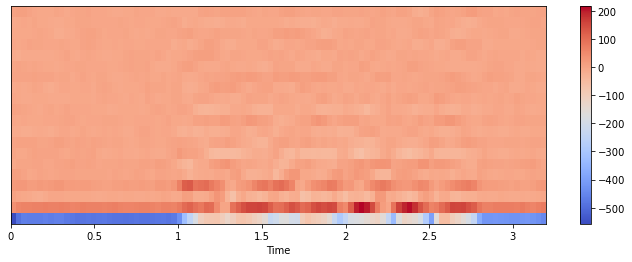

In [8]:
# Extract 'n_mfcc' numbers of MFCCs components (here 20)
x_mfccs = librosa.feature.mfcc(y, sr=sr, n_mfcc=20)

# Plot MFCCs
plt.figure(figsize=(12, 4))
librosa.display.specshow(x_mfccs, sr=sr, x_axis="time")
plt.colorbar()
plt.show()

#### Audio data recap
What we learned so far is that audio data can be represented in many different ways. While the raw data in waveform is very detailed, it has a lot of sample points to consider. This can become computationally very demanding for a machine learning model.



In [9]:
# Shape of the raw data in waveform
y.shape

(50688,)

To gain also some information from the frequency domain of an audio signal, we can compute spectrogram plots. While short-time Fourier transform (STFT) are the quickest way to get there, they are not addressing the way how we humans perceive pitch. For this we can compute the mel spectrogram, which as such scales the y-axis differently.

In [10]:
# Shape of the stft and mel spectrogram
x_stft.shape, x_mel.shape

((1025, 100), (128, 100))

To have an even more compact version of the mel spectrogram, and because it seems to be very useful for speech recognition and other audio based machine learning problems, we also introduced the Mel-frequency cepstral coefficients (MFCCs).



In [11]:
# Shape of the mfccs
x_mfccs.shape

(20, 100)

#### 2. Data cleaning
Now that we understand a bit better what audio data looks like, let’s visualize a few more examples.



C:\Users\56975\anaconda3\envs\adsml\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


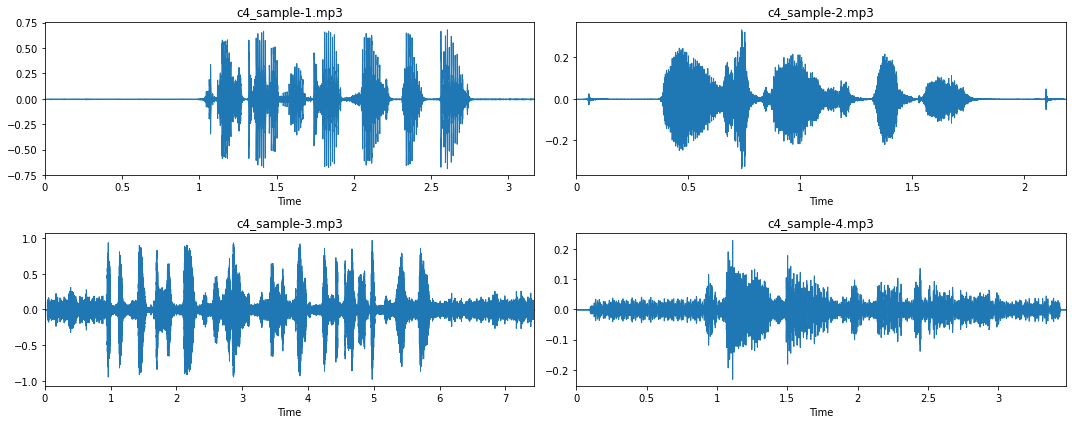

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(15, 6))
for i, ax in enumerate(axs.flatten()):
    fname = "c4_sample-%d.mp3" % (i + 1)
    y, sr = librosa.load(fname, sr=16_000)
    librosa.display.waveplot(y, sr=sr, ax=ax)
    ax.set_title(fname)
plt.tight_layout()
plt.show()

From these four examples, and more importantly, when listening to them, we can gather a few more insights about this audio dataset:

* Most recordings have a long silence period at the beginning and the end of the recording (see sample 1 and 2). This is something we should take care of with ‘trimming’.
* However, in some cases, these silence period are interrupted by a ‘click’, due to the pressing and releasing of the recording buttons (see sample 2).
* Some audio recording don’t have such silence phase, i.e. a straight line (see sample 3 and 4). When listening to these recordings we can observe that this is due to a lot of background noise.

To better understand how this is represented in the frequency domain, let’s look at the corresponding stft spectrogram. Note, we chose stft over mel here because in this particular example, the noise of sample 4 is in the lower frequency range.



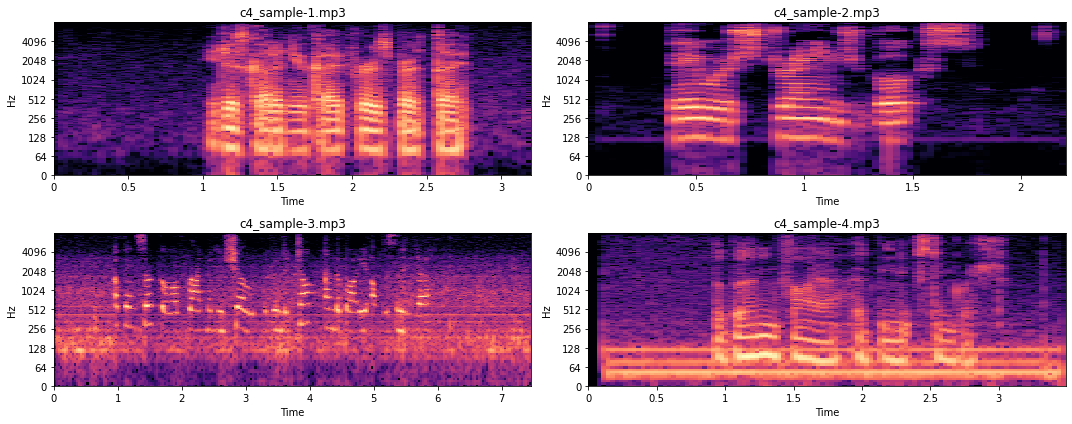

In [13]:
#  The code is the same as before, using the stft-spectrogram routine
fig, axs = plt.subplots(2, 2, figsize=(15, 6))
for i, ax in enumerate(axs.flatten()):
    fname = "c4_sample-%d.mp3" % (i + 1)
    y, sr = librosa.load(fname, sr=16_000)
    x_stft = np.abs(librosa.stft(y))
    x_stft = librosa.amplitude_to_db(x_stft, ref=np.max)
    librosa.display.specshow(x_stft, sr=sr, x_axis="time", y_axis="log", ax=ax)
    ax.set_title(fname)
plt.tight_layout()
plt.show()

When we listen to the audio recordings we can observe that sample 3 has varying background noise covering multiple frequencies, while the background noise in sample 4 is rather constant. This is also what we see in the figures above. Sample 3 is very noisy throughout, while sample 4 has thick horizontal lines. While it is difficult to remove noise from sample 3, it is much simpler to remove it from sample 4. But now, we won’t go into more detail of how this can be done, as this would be beyond the scope of this unit.

So, for now, let’s look into a way of how we can remove this noise, and trim the audio samples. While a more manual approach, using custom filtering functions, might be the best approach to remove noise from audio data, in our case we will go ahead and use the practical python package noisereduce.

In [15]:
!pip install noisereduce

In [16]:
import noisereduce as nr
from scipy.io import wavfile

# Loop through all four samples
for i in range(4):

    # Load audio file
    fname = "c4_sample-%d.mp3" % (i + 1)
    y, sr = librosa.load(fname, sr=16_000)

    # Remove noise from audio sample
    reduced_noise = nr.reduce_noise(y=y, sr=sr, stationary=False)

    #  Save output in a wav file as mp3 cannot be saved to directly
    wavfile.write(fname.replace(".mp3", ".wav"), sr, reduced_noise)

C:\Users\56975\anaconda3\envs\adsml\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
C:\Users\56975\anaconda3\envs\adsml\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


If you listen to the created wav files, you can hear that the noise is almost completely gone. Yes, we also introduced a few more artifacts, but overall, we hope that our noise removal approach did more good than harm.

For the trimming step we can use librosa’s .effects.trim() function. Note, each dataset might need a different top_db parameter for the trimming, so best is to try out a few versions and see what works well. In our case it is top_db=20.



In [17]:
# Loop through all four samples
for i in range(4):

    # Load audio file
    fname = "c4_sample-%d.wav" % (i + 1)
    y, sr = librosa.load(fname, sr=16_000)

    # Trim signal
    y_trim, _ = librosa.effects.trim(y, top_db=20)

    #  Overwrite previous wav file
    wavfile.write(fname.replace(".mp3", ".wav"), sr, y_trim)

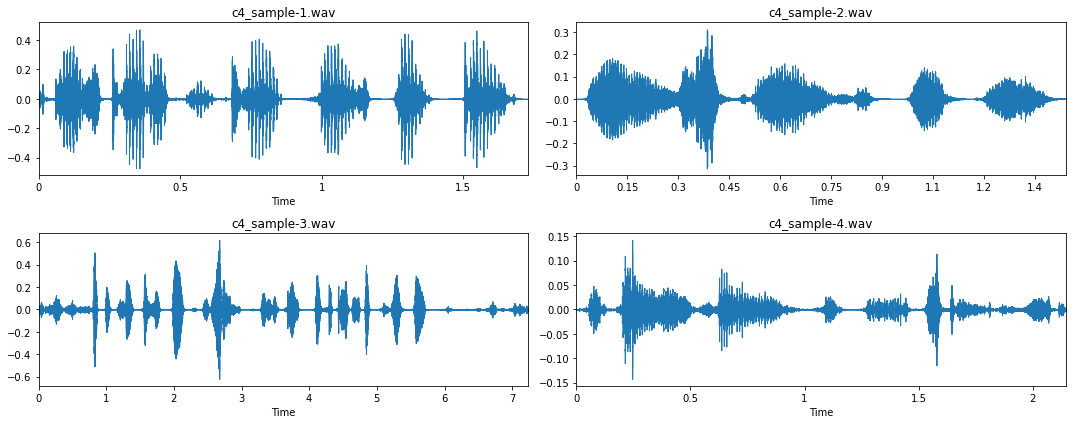

In [18]:
# Let’s now take another look at the cleaned data.

fig, axs = plt.subplots(2, 2, figsize=(15, 6))
for i, ax in enumerate(axs.flatten()):
    fname = "c4_sample-%d.wav" % (i + 1)
    y, sr = librosa.load(fname, sr=16_000)
    librosa.display.waveplot(y, sr=sr, ax=ax)
    ax.set_title(fname)
plt.tight_layout()
plt.show()

#### 3. Feature extraction
Now that our data is clean, let’s go ahead and look into a few audio-specific feature that we could extract. But first, let’s load a file.

In [20]:
# Load data for sample 1
y, sr = librosa.load("c4_sample-1.wav", sr=16_000)

##### Onset detection
Looking at the waveform of a signal, librosa can reasonably well identify the onset of a new spoken word.

C:\Users\56975\anaconda3\envs\adsml\lib\site-packages\librosa\filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(


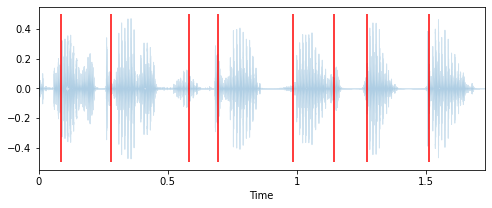

In [21]:
# Extract onset timestamps of words
onsets = librosa.onset.onset_detect(
    y=y, sr=sr, units="time", hop_length=128, backtrack=False
)

# Plot onsets together with waveform plot
plt.figure(figsize=(8, 3))
librosa.display.waveplot(y, sr=sr, alpha=0.2, x_axis="time")
for o in onsets:
    plt.vlines(o, -0.5, 0.5, colors="r")


Therefore, one feature we could extract is the number of onsets detected in a audio sample.

In [22]:
number_of_words = len(onsets)
number_of_words

8

#### Length of an audio recording
Very much related to this is the length of an audio recording. The longer the recording, the more words can be spoken. So let’s compute the length of the recording and the speed at which words are spoken.

In [23]:
# Computes duration in seconds
duration = len(y) / sr
duration

1.728

In [24]:
# Computes number of words per second
words_per_second = number_of_words / duration
words_per_second

4.62962962962963

#### Tempo
Language is a very melodic signal, and each of us has a unique way and speed of speaking. Therefore, another feature that we could extract is the tempo of our speech, i.e. the number of beats that can be detected in an audio signal.

In [25]:
# Computes the tempo of a audio recording
tempo = librosa.beat.tempo(y, sr, start_bpm=10)
tempo

array([41.66666667])

#### Fundamental frequency
The fundamental frequency is the lowest frequency at which a periodic sound appears. In music this is also known as pitch. In the spectrogram plots that we saw before, the fundamental frequency (also called f0) is the lowest bright horizontal strip in the image. While the repetition of the strip pattern above this fundamental are called harmonics.

To better illustrate what we exactly mean, let’s extract the fundamental frequency and plot them in our spectrogram.



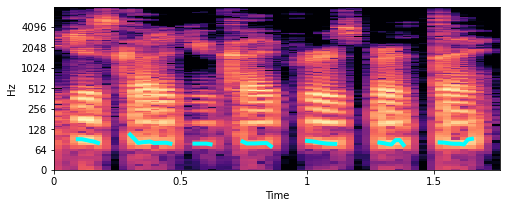

In [26]:
# Extract fundamental frequency using a probabilistic approach
f0, _, _ = librosa.pyin(y, sr=sr, fmin=10, fmax=1500, frame_length=1024)

# Establish timepoint of f0 signal
timepoints = np.linspace(0, duration, num=len(f0), endpoint=False)

# Plot fundamental frequency in spectrogram plot
plt.figure(figsize=(8, 3))
x_stft = np.abs(librosa.stft(y))
x_stft = librosa.amplitude_to_db(x_stft, ref=np.max)
librosa.display.specshow(x_stft, sr=sr, x_axis="time", y_axis="log")
plt.plot(timepoints, f0, color="cyan", linewidth=4)
plt.show()

This seems about write, but how can we now use that for feature engineering? Well, what we could do is compute specific characteristics of this f0.

In [27]:
# Computes mean, median, 5%- and 95%-percentile value of fundamental frequency
f0_values = [
    np.nanmean(f0),
    np.nanmedian(f0),
    np.nanstd(f0),
    np.nanpercentile(f0, 5),
    np.nanpercentile(f0, 95),
]
f0_values

[82.5904075544331,
 80.69649525479105,
 5.720643435507902,
 76.82983560408034,
 92.26959089466533]

There are of course many more audio feature extraction techniques that you could explore. For a nice summary of a few, check out this link.
https://musicinformationretrieval.com/#Signal-Analysis-and-Feature-Extraction

### Machine learning with audio data - Exploration and Modeling

In the previous unit we saw how we can load and process audio data, and how we can extract meaningful data from such recordings. In this unit we will now go a step further and conduct an EDA on a big auditory dataset, as well as create some machine learning models to predict the gender and age of a speaker.

### The Dataset
In the previous unit we only look at 4 out of the 200’000 samples from the 14 GB big Common Voice dataset. This is a lot of data, which means that the data cleaning and feature extraction can take a lot of time.

So to speed up things, we decided to only take a subset of the original dataset. In particular, we only will look at audio samples from speaker with a US accent, who are younger than 70 years old, and where the quality rating of the recording was sufficiently high. This brings the number of good samples already down to 9’000.

After that we went ahead and used the code introduced in the previous unit to load and clean the data, and to extract useful audio features. The end result of all of this can be found in the resource tab. The cleaned audio files can be found in the folder audio_dataset, while the extracted features and the target features age and gender can be found in the file c4_common-voice_dataset.csv.

### Exploratory data analysis (EDA)
Now that we have everything ready, let’s go ahead and explore the dataset.

In [28]:
import pandas as pd

# Load the csv-file
df = pd.read_csv("c4_common-voice_dataset.csv")
print(df.shape)

(9078, 12)


In [29]:
df.head()

,filename,age,gender,nwords,duration,words_per_second,tempo,f0_mean,f0_median,f0_std,f0_5perc,f0_95perc
0,sample_00001.mp3,thirties,male,7,2.628,2.663623,25.000000,102.324770,98.498125,17.991891,80.418300,132.998063
1,sample_00002.mp3,sixties,male,15,2.916,5.144033,27.173913,97.773162,96.799527,17.866865,70.626442,129.735084
2,sample_00003.mp3,twenties,female,18,3.528,5.102041,25.000000,237.412951,234.253711,36.550090,185.338320,301.256951
3,sample_00004.mp3,twenties,male,35,6.516,5.371393,21.306818,189.364906,110.553030,196.566434,90.317152,689.908597
4,sample_00005.mp3,fourties,female,19,5.040,3.769841,19.531250,204.885320,202.755152,21.037004,177.839644,245.332535


Before we do anything, let’s look for missing values that our feature extraction routine might have caused.

In [30]:
df.isna().sum()

filename             0
age                  0
gender               0
nwords               0
duration             0
words_per_second     0
tempo                0
f0_mean             63
f0_median           63
f0_std              63
f0_5perc            63
f0_95perc           63
dtype: int64

It seems that our extraction of the pitch information wasn’t always successful. Given that these are only a few samples, let’s get rid of them.

In [31]:
df.dropna(inplace=True)

### Investigation of features distribution
#### Target features

First, let’s look at the class distributions of our potential target classes age and gender.

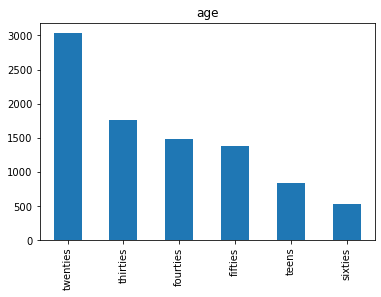

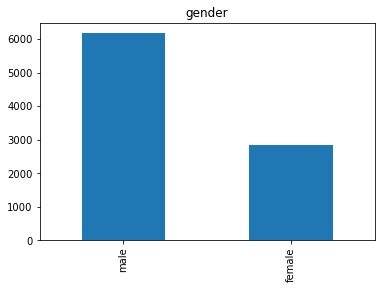

In [32]:
import matplotlib.pyplot as plt

for c in ["age", "gender"]:
    df[c].value_counts().plot.bar(title=c)
    plt.show()

While the classes are imbalanced in age and gender, the imbalance doesn’t seem to be too extreme. Nonetheless, let’s keep that in mind and account for it during model training.

#### Practical data reduction
We decided to keep a big range of ages in this dataset so that you have enough variation in the data, should you chose to explore age as a target in your classification. However, to reduce the overall computational demand on this unit, (i.e. in computer memory, but also in model training time), we will reduce the dataset once more and only keep the age groups 20s, 30s and 40s.



In [33]:
import numpy as np

# Create a mask that only contains 20s, 30s and 40s
mask = []
for c in ["twenties", "thirties", "fourties"]:
    mask.append(df["age"].str.contains(c).values)
mask = np.where(np.sum(mask, axis=0))[0]

# Only keep masked samples
df = df.iloc[mask, :].copy()
df.shape

(6276, 12)

#### Additionally extracted features
As a next step, let’s take a look at the extracted features.

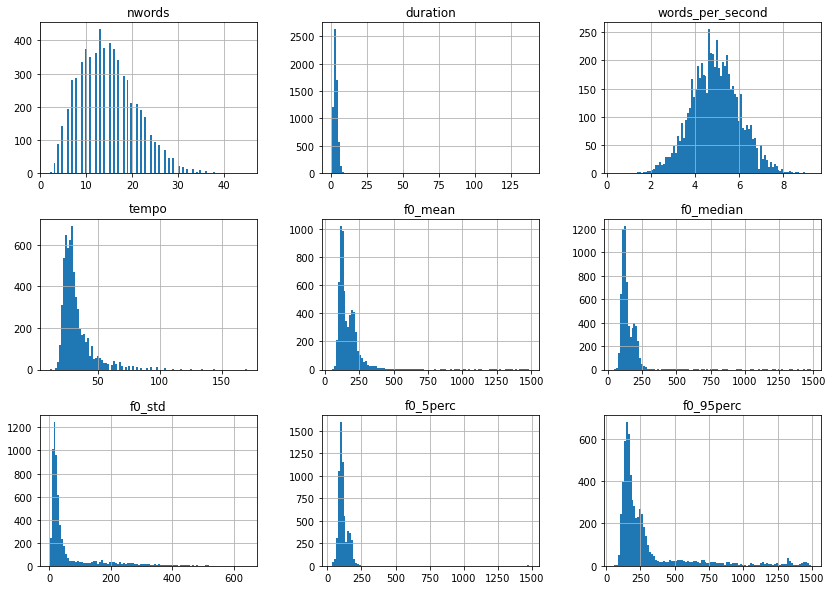

In [34]:
df.drop(columns=["age", "gender", "filename"]).hist(bins=100, figsize=(14, 10))
plt.show()

Except for words_per_second, most of these feature distributions are right skewed and therefore could profit from a log-transformation. So let’s take care of that.

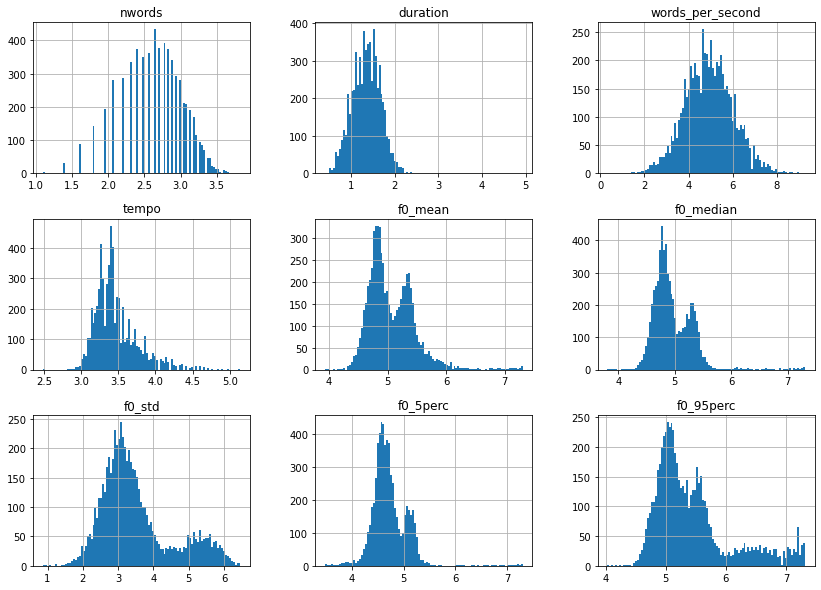

In [35]:
import numpy as np

# Applies log1p on features that are not age, gender, filename or words_per_second
df = df.apply(
    lambda x: np.log1p(x)
    if x.name not in ["age", "gender", "filename", "words_per_second"]
    else x
)

# Let's look at the distribution once more
df.drop(columns=["age", "gender", "filename"]).hist(bins=100, figsize=(14, 10))
plt.show()


Much better, but what is interesting is the fact that the f0 features all seem to have a bimodal distribution. Let’s take a closer look at one of them.



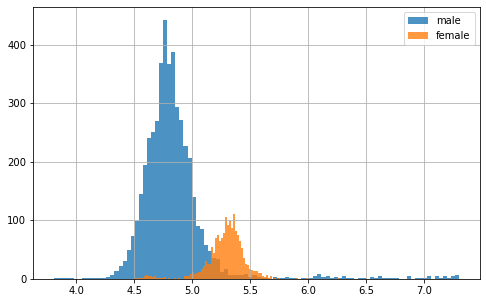

In [36]:
for g in df.gender.unique():
    df[df["gender"].eq(g)]["f0_median"].hist(
        bins=100, figsize=(8, 5), label=g, alpha=0.8
    )
plt.legend()
plt.show()

As suspected, there seems to be a gender effect here! But what we can also see is that some f0 scores (here in particular in males) are much lower and higher than they should be. These could potentially be outliers, due to bad feature extraction. Let’s take a closer look at all data points with the following figure.

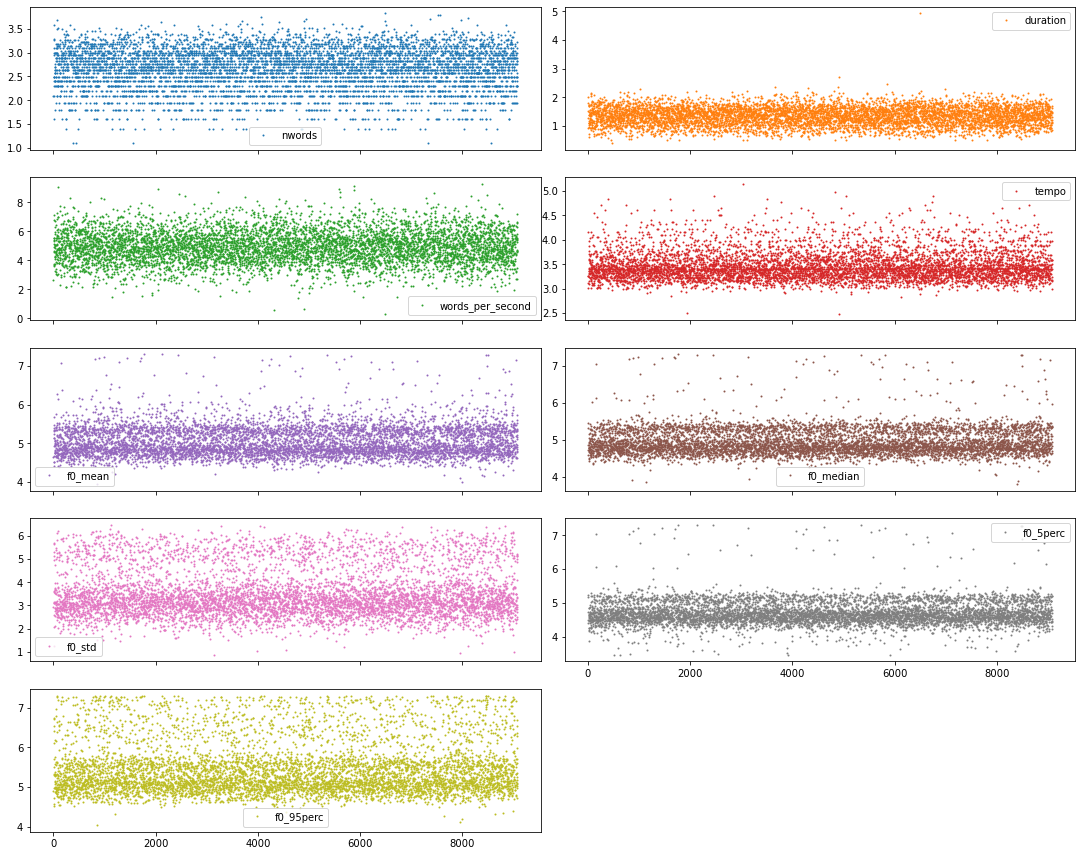

In [37]:
df.plot(lw=0, marker=".", subplots=True, layout=(-1, 2), figsize=(15, 12), markersize=2)
plt.tight_layout()
plt.show()

Given the few number of features and the fact that we have rather nice looking distributions with pronounced tails, we could go through each of them and decide the outlier cut off threshold feature by feature.

But to show you once more how this could be done with a z-score approach, let’s do that instead.

In [38]:
from scipy.stats import zscore

# Only select columns with numbers from the dataframe
df_num = df.select_dtypes(np.number)

# Apply zscore to all numerical features
df_num = df_num.apply(zscore)

# Identify all samples that are below a specific z-value
z_thresh = 3
mask = np.sum(df_num.abs() > z_thresh, axis=1).eq(0)

# Only keep the values in the mask
df = df[mask]
df.shape

(6004, 12)

As you can see, this approach reduced our dataset roughly by 5%, which should be fine.

#### Feature correlation
As a next step, let’s take a look at the correlation between all features. But before we can do that, let’s go ahead and also encode the non-numerical target features. Note, we could use scikit-learn’s OrdinalEncoder to do that, but that would potentially disrupt the correct order in the age feature. So let’s rather perform a manual mapping.



In [39]:
# Map age to appropriate numerical value
df.loc[:, "age"] = df["age"].map({"twenties": 0, "thirties": 1, "fourties": 2})

# Map gender to corresponding numerical value
df.loc[:, "gender"] = df["gender"].map({"male": 0, "female": 1})

C:\Users\56975\anaconda3\envs\adsml\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Now we’re good to go to use pandas .corr() function together with seaborn’s heatmap() to gain more insight about the feature correlation.

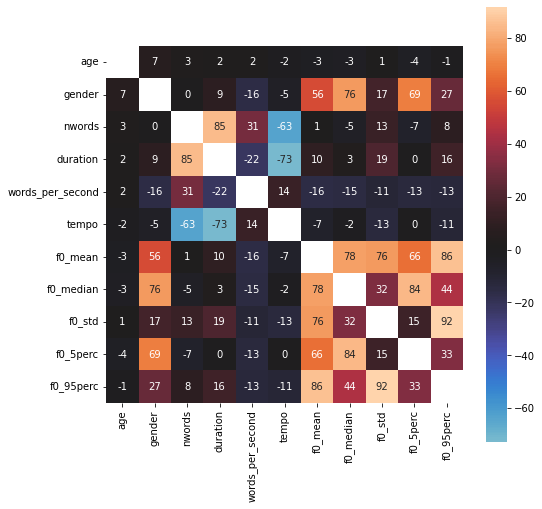

In [40]:
import seaborn as sns

plt.figure(figsize=(8, 8))
df_corr = df.corr() * 100
sns.heatmap(df_corr, square=True, annot=True, fmt=".0f",
            mask=np.eye(len(df_corr)), center=True)
plt.show()

Interesting! What we can see is that our extracted f0 features seem to have a rather strong relationship to gender target, while age doesn’t seem to correlate much with anything.

#### Spectrogram features
For now we haven’t looked at the actual audio recordings during our EDA. As we saw in the previous unit, we have a lot of options (i.e. in waveform or as stft, mel or mfccs spectrogram). For this exploration here, let’s go ahead look at the mel spectrograms as well.

However, before we can do that we need to consider one thing: The audio samples are all of different length, meaning that the spectrograms will also have different length. Therefore, to normalize all samples let’s put each spectrogram into a plot of 3 second length. Meaning, samples that are too short will be filled up with 0s (or in our case -80 dB), and samples that are too long will be cut off.

To do all of this efficiently, let’s create two new helper functions.

In [41]:
import os
import librosa

def resize_spectrogram(spec, length, fact=-80):

    # Create an empty canvas to put spectrogram into
    canvas = np.ones((len(spec), length)) * fact

    if spec.shape[1] <= length:
        canvas[:, : spec.shape[1]] = spec
    else:
        canvas[:, :length] = spec[:, :length]
    return canvas

def compute_mel_spec(filename, sr=16_000, hop_length=512, duration=3.0):

    # Loads the mp3 file
    y, sr = librosa.load(os.path.join("audio_dataset", filename), sr=sr)

    # Compute the mel spectrogram
    x_mel = librosa.feature.melspectrogram(y=y, sr=sr)

    # Apply logarithmic dB-scale to spectrogram and set maximum to 0 dB
    x_mel = librosa.power_to_db(x_mel, ref=np.max)

    # Compute mean strength per frequency for mel spectrogram
    mel_strength = np.mean(x_mel, axis=1)

    # Estimate the desired length of the spectrogram
    length = int(duration * sr / hop_length)

    # Put mel spectrogram into the right shape
    x_mel = resize_spectrogram(x_mel, length, fact=-80)

    return x_mel, mel_strength

Now that everything is ready, let’s extract the spectrograms for all audio samples (this may take ~5min).

In [42]:
# Use this code snippet to suppress all 'librosa' related UserWarnings
import warnings
warnings.filterwarnings("ignore")

# Create arrays to store output into
spec_infos = []

# Loop through all files and extract spectrograms
sr = 16_000
for f in df.filename:
    spec_infos.append(compute_mel_spec(f, sr=sr))

# Aggregate feature types in common variable
mels = np.array([s[0] for s in spec_infos])
mels_strengths = np.array([s[1] for s in spec_infos])

Now that have these spectrogram features as well, let’s perform some EDA on them too!

And because we saw that ‘gender’ seems to have a special relationship to our audio recordings, let’s visualize the average mel spectrogram for both gender separately.

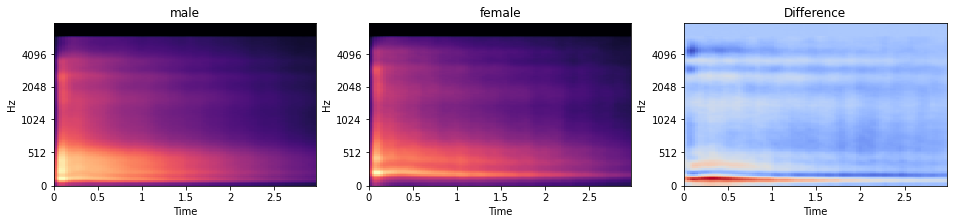

In [43]:
import librosa.display

# Creates a figure with two subplot
fig, axs = plt.subplots(1, 3, figsize=(16, 3))

# Plots mel spectrogram for male speakers
mels_male = np.mean(mels[df["gender"].eq(0)], axis=0)
librosa.display.specshow(mels_male, sr=sr, x_axis="time", y_axis="mel", ax=axs[0])
axs[0].set_title("male")

# Plots mel spectrogram for female speakers
mels_female = np.mean(mels[df["gender"].eq(1)], axis=0)
librosa.display.specshow(mels_female, sr=sr, x_axis="time", y_axis="mel", ax=axs[1])
axs[1].set_title("female")

# Plot gender differences
librosa.display.specshow(
    mels_male - mels_female, sr=sr, x_axis="time", y_axis="mel", ax=axs[2])
axs[2].set_title("Difference")
plt.show()

While it is difficult to see in the individual plot, the difference plot reveals that male speaker have on average lower voices than female. This can be seen by more strength in the lower frequencies (seeing in the red horizontal region) in the difference plot.

To further investigate this property (and to extract some additional features), let’s collapse these spectrogram plots over time (i.e. let’s compute the mean value over the x-axis) and see how each frequency band relates to the target feature age.

Luckily, we already extracted this information with the compute_mel_spec() helper function. So let’s take a look at them.

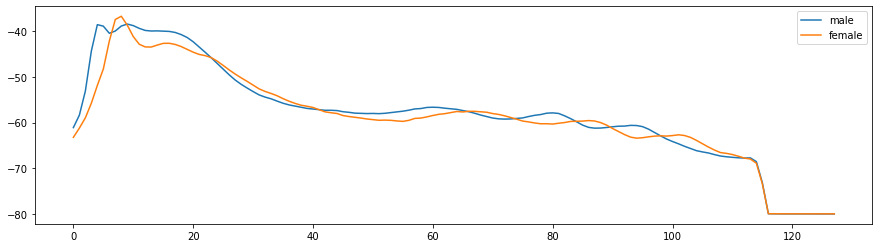

In [44]:
# Plot the mean values for the 128 frequency bands and compare them between genders
plt.figure(figsize=(15, 4))
plt.plot(np.mean(mels_strengths[df["gender"].eq(0)], axis=0), label="male")
plt.plot(np.mean(mels_strengths[df["gender"].eq(1)], axis=0), label="female")
plt.legend()
plt.show()

This plot seems to support our observation of differences in the frequency band strength between male and female speakers, at least in the lower frequencies on the left.

### Machine learning models
Now, we’re ready for the modeling part. And as such, we have multiple options. With regards to models, we could …

train our own classical (i.e. shallow) machine learning models, such as LogisticRegression or SVC.
train our own deep learning models, i.e. deep neural network
use a pretrained neural network from TensorflowHub for feature extraction and then train a shallow or deep model on these high-level features
And with regards to data, we could use …

* the data from the CSV file, combine it with the ‘mel strength’ features from the spectrograms and consider the data as a tabular data set
* the mel-spectrograms alone and consider them as a image data set
* the high-level features from TensorflowHub, combine them with the other tabular data and consider it as a tabular data set as well

There are of course many different approaches and other ways to create the data set for the modeling part, but for now, let’s briefly explore the ones mentioned here.

### Classical (i.e. shallow) machine learning models
As a first approach, let’s take the data from the CSV file and combine it with a simple LogisticRegression model and see how well we can predict the gender of a speaker. So to start, let’s load the data and split it into train and test set.

In [45]:
from sklearn.model_selection import train_test_split

# Select target
target = "gender"
y = df[target].values

# Select relevant features from the dataframe
features = df.drop(columns=["filename", target]).reset_index(drop=True)

# Combine them with the mels strength features
X = pd.concat((features, pd.DataFrame(mels_strengths)), axis=1)

# Create train and test set
x_tr, x_te, y_tr, y_te = train_test_split(
    X, y, train_size=0.8, shuffle=True, stratify=y, random_state=0)

# Plot size of dataset
print(x_tr.shape)

(4803, 138)


Now that the data is ready to be trained, let’s create the model we would like to train. For this, let’s use a Pipeline object, so that we can explore the advantage of certain preprocessing routines (e.g. using scalers or PCA). Furthermore, let’s use GridSearchCV to explore different hyper-parameter combinations, as well to perform cross-validation.

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Create pipeline
pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA()),
        ("logreg", LogisticRegression(class_weight="balanced")),
])

# Create grid
grid = {
    "scaler": [StandardScaler(), RobustScaler(), MinMaxScaler()],
    "pca": [None, PCA(0.99)],
    "logreg__C": np.logspace(-3, 2, num=16),
}

# Create GridSearchCV
grid_cv = GridSearchCV(pipe, grid, cv=4, return_train_score=True, verbose=1)

# Train GridSearchCV
model = grid_cv.fit(x_tr, y_tr)

Fitting 4 folds for each of 96 candidates, totalling 384 fits


Note, that during the definition of the grid space, we can influence if a certain pipeline object is present or not (e.g. using None), but we can also specify different parameters of these objects, with the __ specification.

After the training has finished, we can extract the relevant information from the trained GridSearchCV object and store it in a useful pandas DataFrame.

In [47]:
# Collect results in a DataFrame
cv_results = pd.DataFrame(grid_cv.cv_results_)

# Select the columns we are interested in
col_of_interest = ["param_scaler", "param_pca", "param_logreg__C", "mean_test_score",
                   "mean_train_score", "std_test_score", "std_train_score"]
cv_results = cv_results[col_of_interest]

# Show the dataframe sorted according to our performance metric
cv_results.sort_values("mean_test_score", ascending=False)

,param_scaler,param_pca,param_logreg__C,mean_test_score,mean_train_score,std_test_score,std_train_score
48,StandardScaler(),None,0.464159,0.962316,0.969117,0.007145,0.002062
25,RobustScaler(),None,0.021544,0.962108,0.964259,0.007455,0.001334
71,MinMaxScaler(),PCA(n_components=0.99),4.641589,0.961900,0.965855,0.007474,0.002595
68,MinMaxScaler(),None,4.641589,0.961900,0.967451,0.007924,0.002180
37,RobustScaler(),None,0.1,0.961900,0.965577,0.006374,0.002457
...,...,...,...,...,...,...,...
17,MinMaxScaler(),PCA(n_components=0.99),0.004642,0.901522,0.903463,0.011851,0.001779
8,MinMaxScaler(),None,0.002154,0.881951,0.884239,0.013413,0.001369
11,MinMaxScaler(),PCA(n_components=0.99),0.002154,0.881951,0.884239,0.013413,0.001369
5,MinMaxScaler(),PCA(n_components=0.99),0.001,0.861963,0.862447,0.017179,0.006003


As an addition to the DataFrame output, we could also decide to plot the performance score as a function of one hyperparameter. However, given that we have multiple scalers and PCA approaches, we should create a separate plot for each combination of the other hyperparameters.



In [48]:
from itertools import product

# Establish combinations of different hyperparameters, that isn't the one
# we want to plot on the x-axis
combinations = list(product(grid["scaler"], grid["pca"]))
combinations

[(StandardScaler(), None),
 (StandardScaler(), PCA(n_components=0.99)),
 (RobustScaler(), None),
 (RobustScaler(), PCA(n_components=0.99)),
 (MinMaxScaler(), None),
 (MinMaxScaler(), PCA(n_components=0.99))]

Using this combination information, we can now write a plotting loop that (potentially) provides some interesting and useful insights.

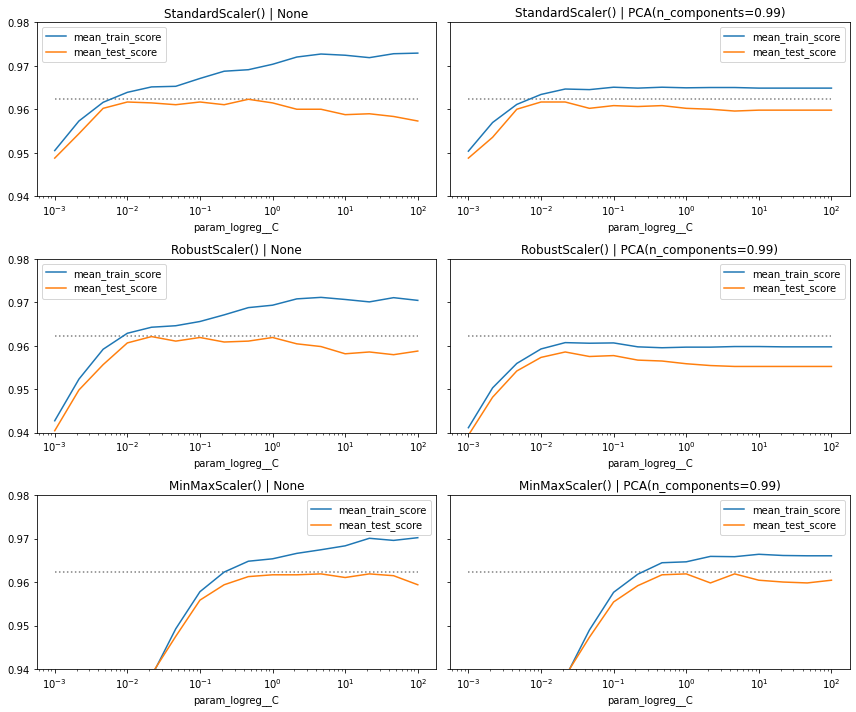

In [49]:
# Creates a figure with multiple subplot
fig, axs = plt.subplots(
    len(grid["scaler"]), len(grid["pca"]), figsize=(12, 10), sharey=True)

# Extract useful information about max performance
max_score = cv_results["mean_test_score"].max()
c_values = cv_results["param_logreg__C"]

# Loop through the subplots and populate them
for i, (s, p) in enumerate(combinations):

    # Select subplot relevant grid search results
    mask = np.logical_and(cv_results["param_pca"].astype("str") == str(p),
                          cv_results["param_scaler"].astype("str") == str(s))
    df_cv = cv_results[mask].sort_values("param_logreg__C").set_index("param_logreg__C")

    # Select relevant axis
    ax = axs.flatten()[i]

    # Plot train and test curves
    df_cv[["mean_train_score", "mean_test_score"]].plot(
        logx=True, title=f"{s} | {p}", ax=ax)

    # Plot best performance metric as dotted line
    ax.hlines(
        max_score, c_values.min(), c_values.max(), color="gray", linestyles="dotted")

# Limit y-axis
plt.ylim(0.94, 0.98)
plt.tight_layout()
plt.show()


Taking the extra step and visualizing the performance metrics as curves often give us relevant additional information, that we wouldn’t get when we just look at the pandas DataFrame.

In this plot we can see that overall, the models perform equally well. Some have a quicker ‘drop-off’ when we decrease the value of C, while other show a wider gap between train and test (here actually validation) score, especially when using PCA.

Having said all that, let’s just go ahead with the best_estimator_ model and see how well it performs on the withheld test set.

In [50]:
# Compute score of the best model on the withheld test set
best_clf = model.best_estimator_
best_clf.score(x_te, y_te)

0.95503746877602

That’s already a very good score, and it is only ~1-2% off from the score we reached on the training and validation set. But to better understand how well our classification model performed, let’s also look at the corresponding confusion matrix. To do this, let’s create a short helper function.

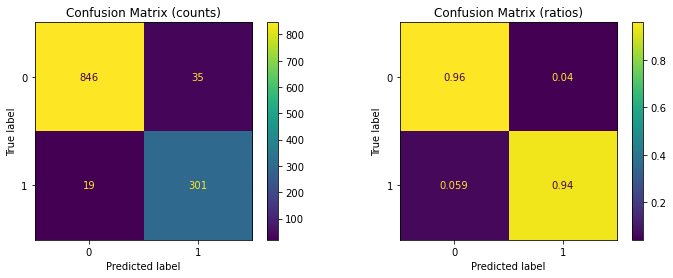

In [51]:
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrices(y_true, y_pred):

    # Create two subplots
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plots the standard confusion matrix
    ax1.set_title("Confusion Matrix (counts)")
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, ax=ax1)

    # Plots the normalized confusion matrix
    ax2.set_title("Confusion Matrix (ratios)")
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, normalize="true", ax=ax2)

    plt.show()

# Compute test set predictions
predictions = best_clf.predict(x_te)

# Plot confusion matrices
plot_confusion_matrices(y_te, predictions)

Another great post-modeling analysis tool is scikit-learn’s classification_report.

### Deep learning, using the mel spectrogram images as input
Let’s no try another modeling approach using deep learning models, more precisely convolutional neural networks. As the name implies, such a model should be run on data that has some spatial dependencies (e.g. time-series or images).

So as in the previous example, let’s create the training and test set, with the corresponding labels.

In [52]:
from sklearn.model_selection import train_test_split

# Select target
target = "gender"
y = df[target].values

# Features will be the mel spectrogram plots
X = mels.copy()

# Create train, validation and test set (given that we don't use GridSearchCV)
x_tr, x_te, y_tr, y_te = train_test_split(
    X, y, train_size=0.8, shuffle=True, stratify=y, random_state=0)
x_tr, x_va, y_tr, y_va = train_test_split(
    x_tr, y_tr, test_size=0.2, shuffle=True, stratify=y_tr, random_state=0)

# Plot size of dataset
print(x_tr.shape)

(3842, 128, 93)


In the previous example we used a Pipeline object to explore different processing steps such as scaler or pca. Here we are much more interested in the images in their original feature space, i.e. applying a PCA might not what we want for a convolutional neural network.

However, a proper scaling is nonetheless important. Knowing that the mel spectrograms go from -80 to 0, we can apply a quick division and addition to get the values scaled between -1 and +1.



In [53]:
# Scales image values to be between -1 and +1
x_tr = x_tr / 40 + 1
x_va = x_va / 40 + 1
x_te = x_te / 40 + 1

Furthermore, the input data for convolutional neural networks also needs a ‘channel’ dimension. In our case we don’t have colored (i.e. RGB) images and only need one channel dimension. So let’s add this missing dimension with the following code.

In [54]:
# Add the 'channel' dimension to the input images
print(f"x_tr has a dimension of {x_tr.shape} before the manipulation.")

x_tr = x_tr[..., None]
x_va = x_va[..., None]
x_te = x_te[..., None]

print(f"x_tr has a dimension of {x_tr.shape} after the manipulation.")

x_tr has a dimension of (3842, 128, 93) before the manipulation.
x_tr has a dimension of (3842, 128, 93, 1) after the manipulation.


Now we are ready to create our neural network model. For this, let’s use a rather standard architecture, containing Conv2D, MaxPool2D, Flatten, Dense, and Dropout layers. We also added some BatchNormalization layers as they can help with the convergence.

In [55]:
from tensorflow import keras
from tensorflow.keras.layers import (Conv2D, BatchNormalization, Dropout,
                                     Flatten, Dense, MaxPool2D)

# Create convolutional neural network and return '.summary()'
model = keras.Sequential()
model.add(Conv2D(filters=32, kernel_size=4, strides=(2, 2), activation="relu",
                 input_shape=x_tr.shape[1:]))
model.add(MaxPool2D(pool_size=2))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=3, strides=(2, 1), activation="relu"))
model.add(MaxPool2D(pool_size=2))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=3, strides=1, activation="relu"))
model.add(MaxPool2D(pool_size=2))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(16, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 63, 45, 32)        544       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 22, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 31, 22, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 20, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 10, 64)        0         
 2D)                                                             
                                                        

The data and the model architecture is ready. As a next step we need to define the compile() parameters.

In [56]:
# Compile the model using Adam's default learning rate
model.compile(optimizer="Adam", loss="binary_crossentropy", metrics=["accuracy"])

And before we can start we should consider two additional things. First, as we have imbalanced classes, we should provide the model with some class weights.|

In [57]:
# Collects the normalized class distributions
class_distribution = pd.value_counts(y_tr, normalize=True)
class_distribution

0    0.733993
1    0.266007
dtype: float64

In [58]:
# Transforms them to class weights
class_weight = len(class_distribution) / class_distribution
class_weight

0    2.724823
1    7.518591
dtype: float64

And secondly, we could establish an EarlyStopping callback to prevent training when the model doesn’t improve on the validation set anymore. As a side note, using the restore_best_weights=True will restore the most successful model during the EarlyStopping patience period.

In [59]:
# Creates 'EarlyStopping' callback
earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

And we’re good to go! Given that we have an early stopping callback, we don’t need to worry about the number of epochs.

In [60]:
#  Trains the neural network
history = model.fit(
    x=x_tr,
    y=y_tr,
    epochs=100,
    batch_size=64,
    validation_data=(x_va, y_va),
    callbacks=[earlystopping_cb],
    class_weight=dict(class_weight),
    verbose=0,
)

Once the training stopped we can once more take a closer look at how the model optimized. In the case of a neural network, this means looking at the different performance metrics we tracked (in our case the loss and the accuracy) and how they changed over the epoch iterations.

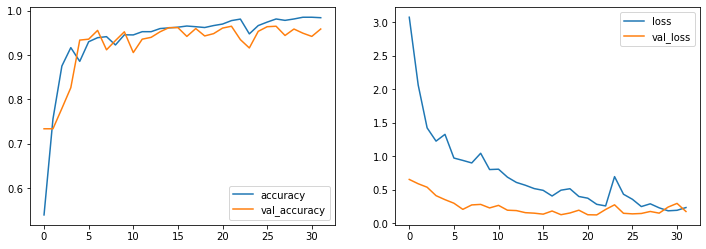

In [61]:
# Plots neural network performance metrics for train and validation
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
results = pd.DataFrame(history.history)
results[["accuracy", "val_accuracy"]].plot(ax=axs[0])
results[["loss", "val_loss"]].plot(ax=axs[1])
plt.show()

This looks reasonably good. So how good is the model in predicting the test set?

In [62]:
# Collect loss and accuracy for the test set
loss_te, accuracy_te = model.evaluate(x_te, y_te)
print(
    f"With a loss at {loss_te:.04f}, the model reaches {100*accuracy_te:.02f}% accuracy."
)

38/38 [==============================] - 4s 100ms/step - loss: 0.1804 - accuracy: 0.9500
With a loss at 0.1804, the model reaches 95.00% accuracy.


This is almost identical to the performance of the model form the previous section. And looking at the confusion matrices reveals that the neural network is slightly more biased to the majority class, than the previous model.



38/38 [==============================] - 5s 101ms/step


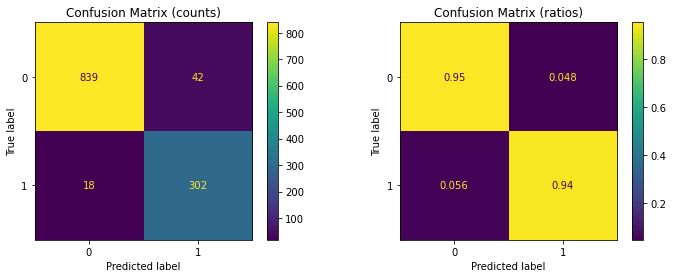

In [63]:
# Compute test set predictions
predictions = np.ravel(model.predict(x_te) > 0.5).astype("int")

# Plot confusion matrices
plot_confusion_matrices(y_te, predictions)

#### Deep learning, using waveform and transfer learning
Last but not least, let’s see how much a pretrained model from Tensorflow Hub could help us here. On Tensorflow Hub we can find numerous models that are great for audio data. To know which one to chose, you need to look into the model description, verify what kind of data it was trained on, what shape and form the input data needs to have, and what the purpose of the model is.

For this unit, let’s use the trill-distilled model. A pretrained model, designed for the non-semantic speech analysis, as for example speech emotion recognition, language identification, etc. Predicting the gender or age should perfectly fall into this region. And with regards to the input data, this model expects the audio files to be recorded with a sampling rate of 16kHz.

So let’s go ahead and download the model.

In [64]:
import tensorflow_hub as hub

# Load the module
module = hub.load(
    "https://tfhub.dev/google/nonsemantic-speech-benchmark/trill-distilled/3"
)

Now that the model is ready, we only need to take the audio samples and pass them through the model to get the high-level features. However, before we do that we need to consider a few more things.

Speech models, such as the trill-distilled return a set of fixed high-level features (in this case 2048 features) for every few 250ms of signal. So, for an audio signal of 5 seconds, we will get 20 times 2048 high-level features. In our case we are not interested in the temporal information of these features (i.e. we don’t need to know these features for every 250ms in time). We are more interested in the overall average values of these features. Therefore, we will compute the average of these 250ms segments.

To keep the amount of data we pass through the model low, let’s only load the first 3 seconds of each audio file. Note, this step might take ~15min.

In [65]:
# Collects high-level features and stores them in the feature matrix
high_features = []
for f in df.filename:

    # Loads first 3 seconds of audio data with 16kHz sampling rate
    signal, sr = librosa.load(os.path.join("audio_dataset", f), sr=16_000, duration=3)

    # Passes audio data through tensorflow hub model
    hub_features = module(samples=signal, sample_rate=sr)["embedding"].numpy()

    # Averages segments of high-level features and adds them to the feature matrix
    high_features.append(np.mean(hub_features, axis=0))

#  Transforms everything back into a numpy array
high_features = np.array(high_features)

Once the high-level features are extracted we can proceed as we did for the first model in this unit. Meaning that we need to define the target classes, and that we can combine these high-level features with the tabular data from the CSV file.



In [66]:
# Collect class labels
target = "gender"
y = df[target].values

# Select relevant features from the dataframe
features = df.drop(columns=["filename", target]).reset_index(drop=True)

# Combine tabular data with high-level features
X = pd.concat((features, pd.DataFrame(high_features)), axis=1)
X.shape

(6004, 2058)

The feature matrix X is ready, the target feature y is ready and we are ready. So let’s once more split the data into a train and a test set, create the pipeline and the parameter grid and fit the models. Note, to reduce computational time, we removed the PCA from the Pipeline and only explore one other scaler.

In [67]:
from sklearn.model_selection import train_test_split

# Create train and test set
x_tr, x_te, y_tr, y_te = train_test_split(
    X, y, train_size=0.8, shuffle=True, stratify=y, random_state=0
)

# Create pipeline
pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(class_weight="balanced")),
    ]
)

# Create grid
grid = {
    "scaler": [None, StandardScaler()],
    "logreg__C": np.logspace(-4, 4, num=17),
}

# Create GridSearchCV
grid_cv = GridSearchCV(pipe, grid, cv=4, return_train_score=True, verbose=1)

# Train GridSearchCV
model = grid_cv.fit(x_tr, y_tr)


Fitting 4 folds for each of 34 candidates, totalling 136 fits


After the models were trained, let’s create once more the same outputs as in the first modeling approach.

In [68]:
# Collect results in a DataFrame
cv_results = pd.DataFrame(grid_cv.cv_results_)

# Select the columns we are interested in
col_of_interest = [
    "param_scaler",
    "param_logreg__C",
    "mean_test_score",
    "mean_train_score",
    "std_test_score",
    "std_train_score",
]
cv_results = cv_results[col_of_interest]

# Show the dataframe sorted according to our performance metric
cv_results.sort_values("mean_test_score", ascending=False).head()

,param_scaler,param_logreg__C,mean_test_score,mean_train_score,std_test_score,std_train_score
16,None,1.0,0.978347,0.989104,0.003482,0.000718
11,StandardScaler(),0.031623,0.978346,0.997224,0.005102,0.000519
9,StandardScaler(),0.01,0.978138,0.993129,0.004384,0.000632
14,None,0.316228,0.977515,0.983066,0.003275,0.001037
18,None,3.162278,0.977513,0.994934,0.002288,0.000360


And as before, let’s use a visual approach to better understand how the different grid parameters interact with the performance metric.



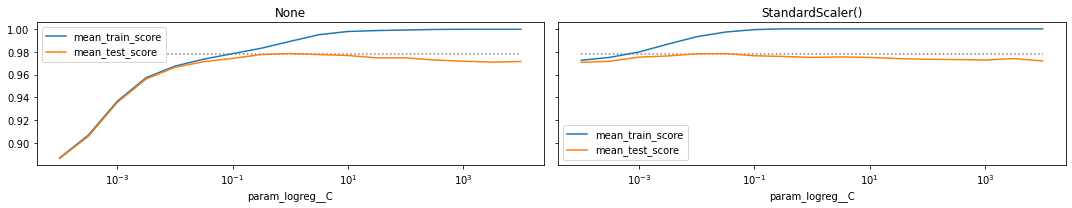

In [69]:
# Creates a figure with multiple subplot
fig, axs = plt.subplots(1, len(grid["scaler"]), figsize=(15, 3), sharey=True)

# Extract useful information about max performance
max_score = cv_results["mean_test_score"].max()
c_values = cv_results["param_logreg__C"]

# Loop through the subplots and populate them
for i, s in enumerate(grid["scaler"]):

    # Select subplot relevant grid search results
    mask = cv_results["param_scaler"].astype("str") == str(s)
    df_cv = cv_results[mask].sort_values("param_logreg__C").set_index("param_logreg__C")

    # Select relevant axis
    ax = axs.flatten()[i]

    # Plot train and test curves
    df_cv[["mean_train_score", "mean_test_score"]].plot(logx=True, title=f"{s}", ax=ax)

    # Plot best performance metric as dotted line
    ax.hlines(
        max_score, c_values.min(), c_values.max(), color="gray", linestyles="dotted")

# Limit y-axis
plt.tight_layout()
plt.show()

The two models look comparable with respect to highest validation score and spread between the train and validation curves. And how does the best model perform on the test set?

In [70]:
# Compute score of the best model on the withheld test set
best_clf = model.best_estimator_
best_clf.score(x_te, y_te)

0.9750208159866778

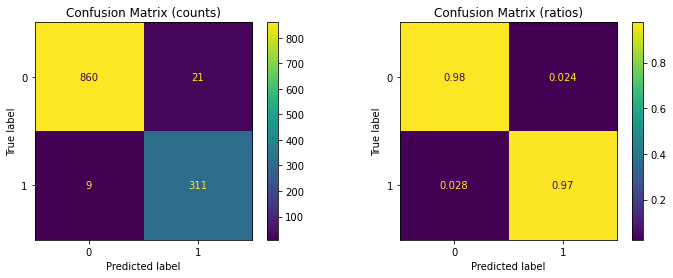

In [71]:
# Oh, that is much better than th other two models. What about the confusion matrix?

# Compute test set predictions
predictions = best_clf.predict(x_te)

# Plot confusion matrices
plot_confusion_matrices(y_te, predictions)

Great! It seems that the high-level features we extracted from the audio samples via transfer learning were very useful!